# Conversion Rate

The goal of this challenge is to build a model that predicts conversion rate and based on the model, come up with ideas to improve revenue.

In [117]:
import pandas as pd
conversion_data = pd.read_csv('conversion_data.csv') # load the dataset

In [118]:
conversion_data.head() # look at the first 5 lines

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [119]:
conversion_data.info() # look at what kind of dtypes are in each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [120]:
conversion_data['source'].unique() # look at unique values of source

array(['Ads', 'Seo', 'Direct'], dtype=object)

In [121]:
conversion_data.iloc[0] # characteristics of the user in first row

country                 UK
age                     25
new_user                 1
source                 Ads
total_pages_visited      1
converted                0
Name: 0, dtype: object

In [122]:
conversion_data.shape # see shape of the table

(316200, 6)

In [123]:
conversion_data['country'].unique() # how many unique countries are there in dataset

array(['UK', 'US', 'China', 'Germany'], dtype=object)

In [124]:
conversion_data.describe() # look at general distributions

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


This tells us that there are no missing values in any of the columns. And the mean conversion rate is 3%, which makes sense.

There is someone who is 123 years old which does not seem right. Look into that a bit further.

In [125]:
ages = conversion_data['age'].unique()
ages.sort()
print(ages) # sort the unique ages in the dataset

[ 17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  72  73  77  79 111 123]


The 111 and 123 year olds don't look right. Let's see how many of those people there are.

In [126]:
conversion_data.groupby(conversion_data['age']>79).count()

,country,age,new_user,source,total_pages_visited,converted
age,,,,,,
False,316198,316198,316198,316198,316198,316198
True,2,2,2,2,2,2


There are only 2 people who are older than 79 - the 111 and 123 year olds! Let's remove them from the dataset.

In [127]:
conversion_data = conversion_data[conversion_data['age']<=79]

In [128]:
conversion_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316198 entries, 0 to 316199
Data columns (total 6 columns):
country                316198 non-null object
age                    316198 non-null int64
new_user               316198 non-null int64
source                 316198 non-null object
total_pages_visited    316198 non-null int64
converted              316198 non-null int64
dtypes: int64(4), object(2)
memory usage: 16.9+ MB


In [129]:
conversion_data.groupby(['country']).count() # look at pure counts by country

,age,new_user,source,total_pages_visited,converted
country,,,,,
China,76602,76602,76602,76602,76602
Germany,13055,13055,13055,13055,13055
UK,48449,48449,48449,48449,48449
US,178092,178092,178092,178092,178092


What this tells us is the website is most likely hosted in the United States. There's a large base in China though.

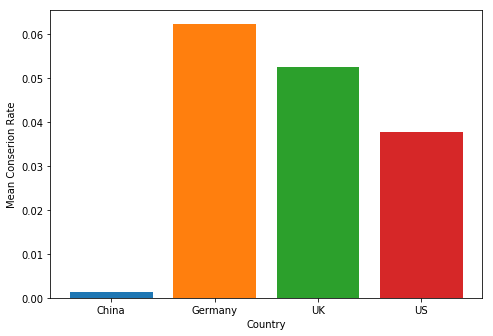

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for country, grp in conversion_data.groupby(['country']):
    ax.bar(country, grp['converted'].mean())
ax.set_xlabel('Country')
ax.set_ylabel('Mean Conserion Rate')
plt.show()

This shows an extremely low conversion rate from users in China.

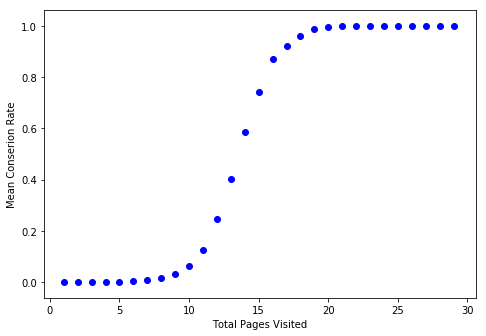

In [131]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for pages_visited, grp in conversion_data.groupby(['total_pages_visited']):
    plt.scatter(pages_visited, grp['converted'].mean(), c= 'b')
ax.set_xlabel('Total Pages Visited')
ax.set_ylabel('Mean Conserion Rate')
plt.show()

This tells us that the more pages a customer visited, the higher the conversion rate!

Before moving forward, we need to encode the categorical features so that we can build our model.

In [151]:
from sklearn.preprocessing import LabelEncoder

In [136]:
country_encoder = LabelEncoder()
encoded_countries = country_encoder.fit_transform(conversion_data['country'])

In [138]:
conversion_data['country_encoded'] = encoded_countries

In [147]:
encoded_sources = pd.get_dummies(conversion_data['source'])

In [148]:
conversion_data = conversion_data.join(encoded_sources)

In [150]:
conversion_data.drop(['country', 'source'], axis=1, inplace=True)
conversion_data.head()

,age,new_user,total_pages_visited,converted,country_encoded,Ads,Direct,Seo
0,25,1,1,0,2,1,0,0
1,23,1,5,0,3,0,0,1
2,28,1,4,0,3,0,0,1
3,39,1,5,0,0,0,0,1
4,30,1,6,0,3,0,0,1


Now, let's work on building a model. The target labels are 0s and 1s so this is a binary classification problem.
We have several options: logistic regression, random forest, gradient boosted forest.

I am going to pick a random forest to predict conversion rate. I pick a random forest because: it usually
requires very little time to optimize it (its default params are often close to the best ones) and it is strong
with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict
conversion, then I will use its partial dependence plots and variable importance to get insights about how
it got information from the variables. Also, I will build a simple tree to find the most obvious user segments
and see if they agree with RF partial dependence plots.

In [152]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.ensemble import RandomForestClassifier

In [153]:
labels = conversion_data['converted']
features = conversion_data.drop(['converted'], axis=1)

In [154]:
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.4, random_state = 0)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5, random_state = 0)

In [155]:
def print_results(cv):
    print('Best params: {}\n'.format(cv.best_params_))
    means = cv.cv_results_['mean_test_score']
    stds = cv.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, cv.cv_results_['params']):
        print('{} +/- {} for {}'.format(round(mean,3), round(std,3), params))

In [156]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,250],
    'max_depth': [4,8,16,None]
}
cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(x_train, y_train)

print_results(cv)

Best params: {'max_depth': 8, 'n_estimators': 250}

0.982 +/- 0.002 for {'max_depth': 4, 'n_estimators': 5}
0.985 +/- 0.001 for {'max_depth': 4, 'n_estimators': 50}
0.985 +/- 0.001 for {'max_depth': 4, 'n_estimators': 250}
0.986 +/- 0.001 for {'max_depth': 8, 'n_estimators': 5}
0.986 +/- 0.001 for {'max_depth': 8, 'n_estimators': 50}
0.986 +/- 0.001 for {'max_depth': 8, 'n_estimators': 250}
0.984 +/- 0.001 for {'max_depth': 16, 'n_estimators': 5}
0.984 +/- 0.001 for {'max_depth': 16, 'n_estimators': 50}
0.984 +/- 0.001 for {'max_depth': 16, 'n_estimators': 250}
0.984 +/- 0.001 for {'max_depth': None, 'n_estimators': 5}
0.984 +/- 0.001 for {'max_depth': None, 'n_estimators': 50}
0.984 +/- 0.001 for {'max_depth': None, 'n_estimators': 250}


Now we will try running the best model on our validation set to see if we are overfitting.

In [157]:
pred = cv.best_estimator_.predict(x_valid)

accuracy = round(accuracy_score(y_valid, pred),3)
precision = round(precision_score(y_valid, pred),3)
recall = round(recall_score(y_valid, pred),3)
print('Accuracy: {} | Precision: {} | Recall: {}'.format(accuracy, precision, recall))

Accuracy: 0.986 | Precision: 0.856 | Recall: 0.663


Here, we note that the recall is pretty poor. Remember, recall is defined as TP/(TP+FN). Thus, we have quite a few false negatives -- those are cases where we predicted that customer did NOT convert, but in really they did.

Now let's look at the feature importances.

In [158]:
importances = cv.best_estimator_.feature_importances_

In [165]:
import numpy as np

random_forest_importances = pd.Series(importances, index=features.columns)
std = np.std([
    cv.best_estimator_.feature_importances_ for tree in cv.best_estimator_.estimators_], axis=0)

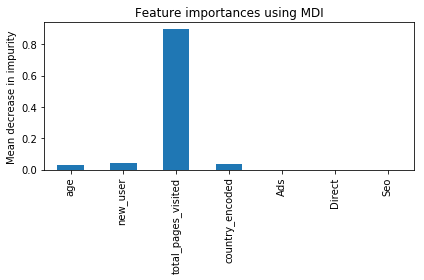

In [166]:
fig, ax = plt.subplots()
random_forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Here, we can see that total_pages_visited is the biggest indicator. However, it's not a very actionable one. We can try rebuilding the random forest without this variable.

In [181]:
features_no_totpages = conversion_data.drop(['total_pages_visited', 'converted'], axis=1)

In [186]:
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(features_no_totpages, labels, test_size=0.4, random_state = 0)
x_valid2, x_test2, y_valid2, y_test2 = train_test_split(x_valid2, y_valid2, test_size=0.5, random_state = 0)

In [197]:
rf2 = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,250],
    'max_depth': [4,8,16,None],
    'class_weight': [{0:0.7, 1:0.3}]
}
cv2 = GridSearchCV(rf2, parameters, cv=5)
cv2.fit(x_train2, y_train2)

print_results(cv2)

Best params: {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': 4, 'n_estimators': 5}

0.968 +/- 0.0 for {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': 4, 'n_estimators': 5}
0.968 +/- 0.0 for {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': 4, 'n_estimators': 50}
0.968 +/- 0.0 for {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': 4, 'n_estimators': 250}
0.968 +/- 0.0 for {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': 8, 'n_estimators': 5}
0.968 +/- 0.0 for {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': 8, 'n_estimators': 50}
0.968 +/- 0.0 for {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': 8, 'n_estimators': 250}
0.968 +/- 0.0 for {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': 16, 'n_estimators': 5}
0.968 +/- 0.0 for {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': 16, 'n_estimators': 50}
0.968 +/- 0.0 for {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': 16, 'n_estimators': 250}
0.968 +/- 0.0 for {'class_weight': {0: 0.7, 1: 0.3}, 'max_depth': None, 'n_estimators': 5}
0.968 +/- 0.0 for {'c

In [199]:
pred2 = cv2.best_estimator_.predict(x_valid2)

accuracy2 = round(accuracy_score(y_valid2, pred2),3)
precision2 = round(precision_score(y_valid2, pred2),3)
recall2 = round(recall_score(y_valid2, pred2),3)
print('Accuracy: {} | Precision: {} | Recall: {}'.format(accuracy2, precision2, recall2))

Accuracy: 0.968 | Precision: 0.0 | Recall: 0.0


C:\Users\Min-A\Anaconda2\envs\py35\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [200]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_valid2, pred2)

array([[61203,     0],
       [ 2037,     0]], dtype=int64)

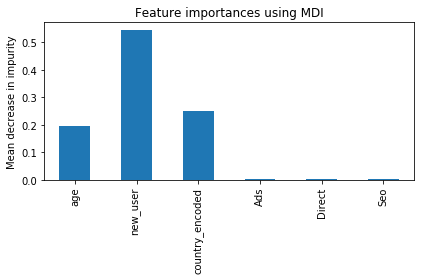

In [202]:
importances2 = cv2.best_estimator_.feature_importances_
random_forest_importances2 = pd.Series(importances2, index=features_no_totpages.columns)
std2 = np.std([
    cv2.best_estimator_.feature_importances_ for tree in cv2.best_estimator_.estimators_], axis=0)

fig, ax = plt.subplots()
random_forest_importances2.plot.bar(yerr=std2, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

What this tells us is new_user, country, and age are the most important features determining conversion rate.

We can try creating partial dependence plots for the training dataset.

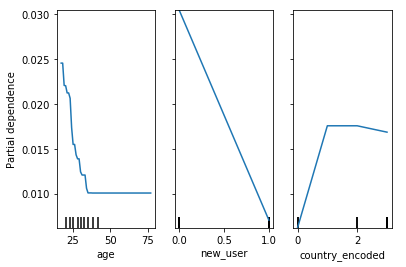

In [206]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(cv2.best_estimator_, x_train2, ['age', 'new_user', 'country_encoded'])

In [208]:
country_encoder.inverse_transform([0,1,2,3])

array(['China', 'Germany', 'UK', 'US'], dtype=object)

Notes:
1. The site works well for young people. Tell marketing to advertise and use marketing channels that are more likely to reach young people.
2. The works well for new users=0, meaning works well for old users. Targeted emails with offers to bring them back to the site might be worth a try.
3. The site is terrible for China. Maybe it is poorly translated. Need to look into that.
4. The site works well for Germany. Might try targeted marketing towards Germans.